## Step 1: Set up Your Enivornment

In [66]:
pip install yfinance pandas numpy matplotlib seaborn gym stable-baselines3 ta gymnasium


Note: you may need to restart the kernel to use updated packages.


## Step 2: Pull Historical Spy Data Using yfinance

In [68]:
import yfinance as yf
import pandas as pd

# 1. Download SPY data
spy = yf.download("SPY", start="2015-01-01", end="2024-12-31")

# 2. Simple Moving Averages
spy['SMA_50'] = spy['Close'].rolling(window=50).mean()
spy['SMA_200'] = spy['Close'].rolling(window=200).mean()

# 3. RSI (14-period) manually
delta = spy['Close'].diff()
gain  = delta.where(delta > 0, 0.0)
loss  = -delta.where(delta < 0, 0.0)
window = 14
avg_gain = gain.ewm(alpha=1/window, min_periods=window, adjust=False).mean()
avg_loss = loss.ewm(alpha=1/window, min_periods=window, adjust=False).mean()
rs = avg_gain / avg_loss
spy['RSI'] = 100 - (100 / (1 + rs))

# 4. MACD (12,26,9) manually
ema12 = spy['Close'].ewm(span=12, adjust=False).mean()
ema26 = spy['Close'].ewm(span=26, adjust=False).mean()
macd_line = ema12 - ema26
signal   = macd_line.ewm(span=9, adjust=False).mean()
spy['MACD'] = macd_line - signal

# 5. Bollinger Bands (20-period, ±2σ)
mid = spy['Close'].rolling(window=20).mean()
std = spy['Close'].rolling(window=20).std()
spy['BB_High'] = mid + 2 * std
spy['BB_Low']  = mid - 2 * std

# 6. Clean up
spy.dropna(inplace=True)

# 7. Inspect
print(spy.tail())

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume  \
Ticker             SPY         SPY         SPY         SPY       SPY   
Date                                                                   
2024-12-23  592.906433  593.514589  585.897488  589.117842  57635800   
2024-12-24  599.496582  599.536501  593.684050  594.272307  33160100   
2024-12-26  599.536499  600.673034  596.286267  597.701991  41219100   
2024-12-27  593.225464  595.987176  588.988210  595.747844  64969300   
2024-12-30  586.455811  589.965273  582.657240  586.126844  56578800   

Price           SMA_50     SMA_200        RSI      MACD     BB_High  \
Ticker                                                                
Date                                                                  
2024-12-23  587.972010  546.518456  49.847440 -2.209400  610.372345   
2024-12-24  588.349675  546.999485  56.013038 -1.463218  610.564704   
2024-12-26  588.818362  547.453644  56.048283 -0.940079  610.714940 

## Step 3 Define Custom Gym Environment

In [75]:
# %% Cell 3 — Define the Gymnasium Trading Environment
import gymnasium as gym
import numpy as np
from gymnasium import spaces

class SPYTradingEnv(gym.Env):
    """Gymnasium environment for SPY trading with technical indicators."""
    metadata = {'render_modes': ['human']}
    
    def __init__(self, df, init_balance=100_000):
        super().__init__()
        self.df = df.copy().reset_index(drop=True)
        self.init_balance = init_balance

        # ← Make sure this is the Gymnasium version
        self.action_space = spaces.MultiDiscrete([3])
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(10,), dtype=np.float32
        )

    def reset(self, *, seed=None, return_info=True, options=None):
        super().reset(seed=seed)
        self.step_idx = 0
        self.balance = self.init_balance
        self.shares  = 0
        self.port_val = self.init_balance
        obs = self._get_obs()
        info = {}
        return (obs, info) if return_info else obs

    def _get_obs(self):
        row = self.df.iloc[self.step_idx]
        return np.array([
            float(row['Close']),
            float(row['RSI']),
            float(row['MACD']),
            float(row['SMA_50']),
            float(row['SMA_200']),
            float(row['BB_High']),
            float(row['BB_Low']),
            float(self.balance),
            float(self.shares),
            float(self.port_val),
        ], dtype=np.float32)

    def step(self, action):
        action = int(action[0])        # unwrap from MultiDiscrete([3])
        price  = float(self.df.iloc[self.step_idx]['Close'])
        prev   = self.port_val
        if action == 0:
            self.balance += self.shares * price
            self.shares = 0
        elif action == 2:
            n = self.balance // price
            self.balance -= n * price
            self.shares += n

        self.step_idx += 1
        terminated = self.step_idx >= len(self.df) - 1
        self.port_val = self.balance + self.shares * price
        reward = self.port_val - prev
        obs, info = self._get_obs(), {'portfolio_value': self.port_val}
        return obs, reward, terminated, False, info

    def render(self):
        print(f"Step {self.step_idx}: Bal={self.balance:.2f}, "
              f"Shr={self.shares}, Port={self.port_val:.2f}")

## Step 4 Train Agent

In [77]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Wrap env for SB3
def make_env():
    return SPYTradingEnv(spy)

vec_env = DummyVecEnv([make_env])

# Instantiate PPO
model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=1,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=64,
    n_epochs=10
)

# Train
model.learn(total_timesteps=200_000)

# Save
model.save("ppo_spy_agent")

Using cpu device


/var/folders/ll/cvqls06d7156l6ks5dqkj5940000gn/T/ipykernel_4900/2311429281.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['Close']),
/var/folders/ll/cvqls06d7156l6ks5dqkj5940000gn/T/ipykernel_4900/2311429281.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['RSI']),
/var/folders/ll/cvqls06d7156l6ks5dqkj5940000gn/T/ipykernel_4900/2311429281.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['MACD']),
/var/folders/ll/cvqls06d7156l6ks5dqkj5940000gn/T/ipykernel_4900/2311429281.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['SMA_50']),
/var/folde

-----------------------------
| time/              |      |
|    fps             | 2313 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1952        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011798149 |
|    clip_fraction        | 0.0719      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -3.1e-06    |
|    learning_rate        | 0.0003      |
|    loss                 | 3.6e+06     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00487    |
|    value_loss           | 7.25e+06    |
-----------------------------------------
----------------------------------

## Step 5 Evaluate and Plot

/var/folders/ll/cvqls06d7156l6ks5dqkj5940000gn/T/ipykernel_4900/2311429281.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['Close']),
/var/folders/ll/cvqls06d7156l6ks5dqkj5940000gn/T/ipykernel_4900/2311429281.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['RSI']),
/var/folders/ll/cvqls06d7156l6ks5dqkj5940000gn/T/ipykernel_4900/2311429281.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['MACD']),
/var/folders/ll/cvqls06d7156l6ks5dqkj5940000gn/T/ipykernel_4900/2311429281.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(row['SMA_50']),
/var/folde

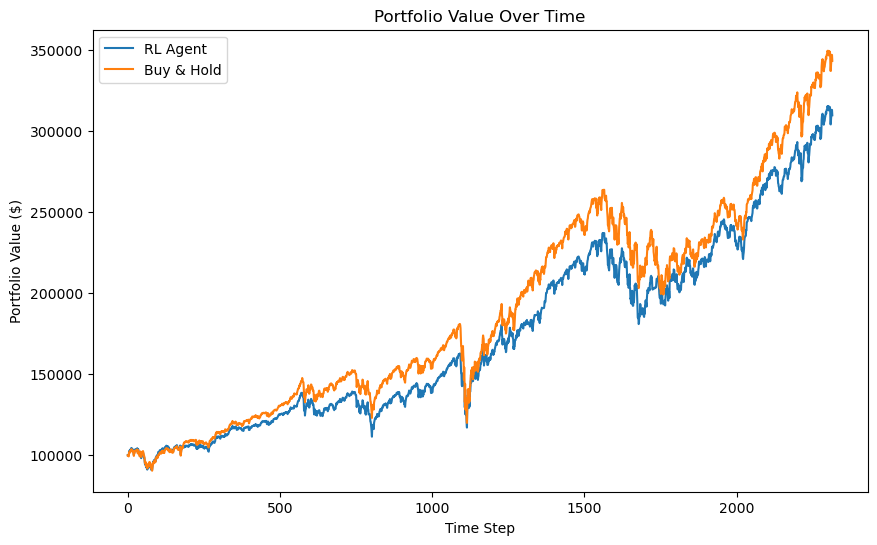

In [82]:
from stable_baselines3 import PPO
import matplotlib.pyplot as plt

# Create a fresh, non-vectorized Gymnasium env
env = SPYTradingEnv(spy)

# Gymnasium reset returns (obs, info)
obs, _ = env.reset()

portfolio_values = []
done = False

while not done:
    # Pass only the observation array to predict()
    action, _ = model.predict(obs)
    
    # Gymnasium step returns (obs, reward, terminated, truncated, info)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    
    portfolio_values.append(info['portfolio_value'])

# Simple Buy & Hold benchmark
buy_hold = spy['Close'] / spy['Close'].iloc[0] * env.init_balance

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(portfolio_values,    label="RL Agent")
plt.plot(buy_hold.values[:len(portfolio_values)], label="Buy & Hold")
plt.title("Portfolio Value Over Time")
plt.xlabel("Time Step")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.savefig("ppo_spy_performance.png", dpi=300, bbox_inches='tight')
plt.show()